In [200]:
import importlib, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import sklearn.metrics.cluster as clust
from tqdm.notebook import tqdm
import data_processing.import_data as imp
import data_processing.partition_data as prt
from data_processing.load_env import load_env
import plot_functions.format_axis as fmt


In [8]:
importlib.reload(imp)
env = load_env()
sub_dir, files, paths = imp.generate_subject_file_path_list(env)
long_data = imp.import_all_longitudinal_files(clean_only=True, add_demog=True)
print('REMOVING SUBJECT m2_0048')
long_data = long_data[long_data.subject_id != 'm2_0048']
print('Remaining Subjects:', long_data.subject_id.nunique())

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 0 subjects 33 remain
	Filtering for time points newer than June 2016
	Adding Demographic information to longitudinal data
REMOVING SUBJECT m2_0048
Remaining Subjects: 32


In [107]:
import data_processing.reshape_data as rd
importlib.reload(rd)
importlib.reload(prt)
min_days = 14
lengths = []
sequences = []
end_sevs = []
start_sevs = []

data_dict = {
    'subject_id': [],
    'start': [],
    'start_date': [],
    'end': [],
    'step_diff': [],
    'call_diff': [],
    'n_migraines': [],
    'start_sev': [],
    'start_anx': [],
    'end_sev': [],
    'end_mig_freq': [],
}


for fp in tqdm(paths):
    subject_data = imp.import_longitudinal_file(fp, True)
    if subject_data.subject_id.unique()[0] == 'm2_0048':
        print('Skipping m2_0048')
        continue
    chunks = prt.two_week_subsets(subject_data, min_days, verbose=False)
    sequence = []
    for d in chunks:
        data = d.sort_values(by='Date', ascending=True)
        start = data['start'].unique()[0]
        end = data['end'].unique()[0]
        h1, h2 = prt.split_half(data)
        sid = data.subject_id.unique()[0]
        if 'Step count' not in data.columns:
            print('No Step Count', sid)
            step_diff = np.nan
        else:
            step_diff = h2['Step count'].mean() - h1['Step count'].mean()   
            
        call_diff = h2['outgoing_calls'].mean() - h1['outgoing_calls'].mean()   
        
        n_migraines = rd.melt_occurrances('mbrep_start_date', data).dropna().mbrep_start_date.count()
        start_sev = data['start_sev'].unique()[0]
        start_anx = data['start_anx'].unique()[0]
        end_sev = data.end_sev.unique()[0]
        end_mig_freq = data.end_mig_freq.unique()[0]
        
        data_dict['subject_id'].append(sid)
        data_dict['start'].append(start)
        data_dict['start_date'].append(data['Date'].min())
        data_dict['end'].append(end)
        data_dict['step_diff'].append(step_diff)
        data_dict['call_diff'].append(call_diff)
        data_dict['n_migraines'].append(n_migraines)
        data_dict['start_sev'].append(start_sev)
        data_dict['start_anx'].append(start_anx)
        data_dict['end_sev'].append(end_sev)
        data_dict['end_mig_freq'].append(end_mig_freq)
        
data_df = pd.DataFrame.from_dict(data_dict).dropna()
data_df.describe(percentiles=[.5])

Skipping m2_0048



,step_diff,call_diff,n_migraines,start_sev,start_anx,end_sev,end_mig_freq
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,338.982509,0.164520,2.380435,50.417391,33.831522,48.938043,0.163043
std,1932.139257,3.111972,2.510822,17.254804,17.819195,18.672038,0.190114
min,-5048.408170,-7.190476,0.000000,9.700000,0.000000,9.700000,0.000000
50%,233.755086,0.000000,2.000000,51.250000,33.200000,50.050000,0.142857
max,5861.416667,18.400000,11.000000,82.100000,78.400000,83.200000,1.000000


In [217]:
data_df.subject_id.nunique()

29

## Mig/Dep Only feature model

In [207]:
sequences = []
lengths = []
end_sevs = []
end_mig_freqs = []
start_sevs = []
sids = []
last_sid = ''
last_end = ''
sequence = None

# Future work will look at including start anxiety as well
#features = ['n_migraines', 'start_sev', 'start_anx']
features = ['n_migraines', 'start_sev']

for (sid, start, end), df in data_df.dropna().groupby(['subject_id', 'start', 'end']):
    if df.shape[0] != 1:
        print(df)
    event = df[features].to_numpy()[0]
    if (sid == last_sid) and (start == last_end):
        sequence.append(event)
    else:
        if sequence:
            sequences.append(sequence)
            lengths.append(len(sequence))
        sequence = [event]

    last_sid = sid
    last_end = end
    end_sevs.append(df.end_sev.unique()[0])
    end_mig_freqs.append(df.end_mig_freq.unique()[0])
    start_sevs.append(df.start_sev.unique()[0])
    sids.append(sid)
        
sequences.append(sequence)
lengths.append(len(sequence))
X = np.concatenate(sequences)

lengths = np.array(lengths).astype(int)
end_sevs = np.array(end_sevs)
end_mig_freqs = np.array(end_mig_freqs)

print('Data Shape', X.shape,'\nN-Sequences:', len(lengths))

Data Shape (92, 2) 
N-Sequences: 38


In [208]:
steps = 25
mig_t = np.linspace(0,1,steps)
mdd_t = np.linspace(0,83,steps)
mesh = np.array(np.meshgrid(mig_t,mdd_t)).T.reshape(-1,2)

categories = []

for mig_thresh, mdd_thresh in tqdm(mesh):
    is_mdd = (end_sevs >= mdd_thresh).astype(int)
    is_mig = (end_mig_freqs >= mig_thresh).astype(int)
    cats = np.char.array(is_mdd.astype(str)) + np.char.array(is_mig.astype(str))
    if len(categories):
        if not np.array_equal(cats, categories[-1]):
            categories.append(cats)
    else:
        categories.append(cats)
cat_len = len(categories)
cat_len

550

In [209]:
n_components=4
n_iter=1000
cov='full'

i = 0
j = 0
max_amis = np.zeros(len(lengths))
mig_ths = np.zeros(len(lengths))
mdd_ths = np.zeros(len(lengths))
for l in tqdm(lengths):
    test = X[i:i+l]
    test_l = [l]
    
    train = np.concatenate([X[:i], X[i+l:]])
    train_l = np.concatenate([lengths[:j], lengths[j+1:]]).astype(int)
    model = GaussianHMM(
        n_components=n_components,
        covariance_type='full',
        n_iter=1000,
    ).fit(train, train_l)
    mod_out = model.predict(X, lengths)
    amis = np.zeros(cat_len)
    k = 0
    for cats in categories:
        ami = clust.adjusted_mutual_info_score(cats, mod_out)
        amis[k] = ami
        k += 1
    max_amis[j] = amis.max()
        
    i = i + l
    j += 1

In [210]:
print('Mean:',max_amis.mean())
print('Std:', max_amis.std())
print('Min:', max_amis.min())
print('Max:', max_amis.max())
max_amis

Mean: 0.28477633025617016
Std: 0.02198273253821331
Min: 0.25738967095611515
Max: 0.3565126579887369


array([0.28965354, 0.30614704, 0.28965354, 0.28965354, 0.32431564,
       0.30922169, 0.2713643 , 0.27570411, 0.35651266, 0.28965354,
       0.26445828, 0.26794505, 0.26445828, 0.27756044, 0.26794505,
       0.26794505, 0.26445828, 0.28965354, 0.26794505, 0.26794505,
       0.30614704, 0.32187143, 0.27597607, 0.27597607, 0.26212628,
       0.3013154 , 0.26353249, 0.28965354, 0.25738967, 0.27652283,
       0.27390535, 0.26076078, 0.26445828, 0.32295039, 0.30614704,
       0.2713643 , 0.29955639, 0.28965354])

## + Continuous Monitering Feature Model

In [211]:
sequences = []
lengths = []
end_sevs = []
end_mig_freqs = []
start_sevs = []
sids = []
last_sid = ''
last_end = ''
sequence = None

# Future work will include start anxiety scores as well
#features = ['step_diff', 'call_diff', 'n_migraines', 'start_sev', 'start_anx']
features = ['step_diff', 'call_diff', 'n_migraines', 'start_sev']

for (sid, start, end), df in data_df.dropna().groupby(['subject_id', 'start', 'end']):
    if df.shape[0] != 1:
        print(df)
    event = df[features].to_numpy()[0]
    if (sid == last_sid) and (start == last_end):
        sequence.append(event)
    else:
        if sequence:
            sequences.append(sequence)
            lengths.append(len(sequence))
        sequence = [event]

    last_sid = sid
    last_end = end
    end_sevs.append(df.end_sev.unique()[0])
    end_mig_freqs.append(df.end_mig_freq.unique()[0])
    start_sevs.append(df.start_sev.unique()[0])
    sids.append(sid)
        
sequences.append(sequence)
lengths.append(len(sequence))
X = np.concatenate(sequences)

lengths = np.array(lengths).astype(int)
end_sevs = np.array(end_sevs)
end_mig_freqs = np.array(end_mig_freqs)

print('Data Shape', X.shape,'\nN-Sequences:', len(lengths))

Data Shape (92, 4) 
N-Sequences: 38


In [212]:
n_samples = len(lengths)

In [213]:
n_components=4
n_iter=1000
cov='full'

i = 0
j = 0
n_samples = len(lengths)
max_amis_2 = np.zeros(n_samples)
mig_ths = np.zeros(n_samples)
mdd_ths = np.zeros(n_samples)
for l in tqdm(lengths):
    test = X[i:i+l]
    test_l = [l]
    
    train = np.concatenate([X[:i], X[i+l:]])
    train_l = np.concatenate([lengths[:j], lengths[j+1:]]).astype(int)
    model = GaussianHMM(
        n_components=n_components,
        covariance_type='full',
        n_iter=1000,
    ).fit(train, train_l)
    mod_out_2 = model.predict(X, lengths)
    amis = np.zeros(cat_len)
    k = 0
    for cats in categories:
        ami = clust.adjusted_mutual_info_score(cats, mod_out_2)
        amis[k] = ami
        k += 1
    max_amis_2[j] = amis.max()
        
    i = i + l
    j += 1

In [214]:
print('Mean:',max_amis_2.mean())
print('Std:', max_amis_2.std())
print('Min:', max_amis_2.min())
print('Max:', max_amis_2.max())
max_amis_2

Mean: 0.1932417800203281
Std: 0.034083510812160156
Min: 0.10013479175801562
Max: 0.2342591590939904


array([0.21237461, 0.20546761, 0.12241558, 0.21239639, 0.21330768,
       0.20526445, 0.20526445, 0.17655352, 0.15472613, 0.14455235,
       0.20802699, 0.21239639, 0.21643313, 0.23425916, 0.222365  ,
       0.21239639, 0.2181633 , 0.20526445, 0.2181633 , 0.2181633 ,
       0.21151184, 0.13381245, 0.20802699, 0.22017888, 0.20534176,
       0.20046431, 0.18384106, 0.1853357 , 0.12623479, 0.10013479,
       0.20790733, 0.19113335, 0.21151184, 0.10620321, 0.20526445,
       0.20790733, 0.20802699, 0.21239639])

Text(0.5, 1.0, 'P: 1.55E-14, t: 1.22E+01')

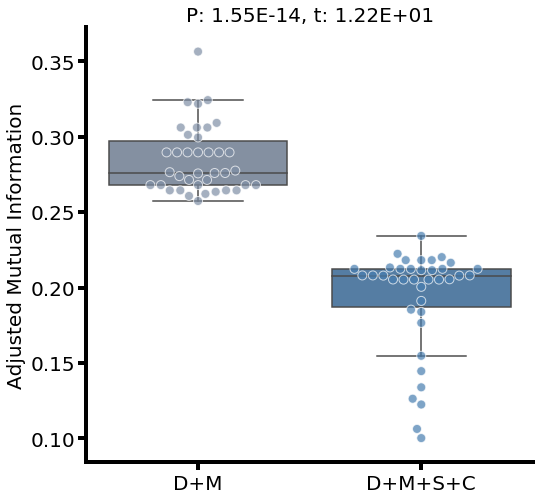

In [220]:
from decimal import Decimal
fig, ax = plt.subplots(figsize=(8,8))
x = (['D+M']*n_samples) + (['D+M+S+C'] * n_samples)
y = np.concatenate([max_amis, max_amis_2])
palette = ['#7f8fa6', '#487eb0']
sns.boxplot(
    x=x,
    y=y,
    ax=ax,
    palette=palette,
    fliersize=0,
)
sns.swarmplot(
    x=x,
    y=y,
    ax=ax,
    alpha=0.7,
    linewidth=1,
    palette=palette,
    edgecolor='white',
    s=9
)
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=20,
)
ax.set_ylabel('Adjusted Mutual Information')
t_value, p_value = stats.ttest_rel(max_amis, max_amis_2)
p_value_sn = '%.2E' % Decimal(p_value)
t_value_sn = '%.2E' % Decimal(t_value)
ax.set_title('P: ' + p_value_sn + ', t: ' + t_value_sn, fontsize=20)